# Experiments with EM Algorithm

## Initialization and Basic Code

In this notebook, I will leverage the cleaned data from the `crime-data.ipynb` notebook to provide clusters of the different data sets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rm
import os
from EM import em_algorithm as em
from EM import utils as ut

%matplotlib inline
%load_ext autoreload
%autoreload

# Fix random seed
np.random.seed(256)

In [2]:
location = os.getcwd() + '/CleanedData'

# Get the data
data1 = pd.read_csv(os.path.join(location, 'dataset1.csv')).to_numpy()
data2 = pd.read_csv(os.path.join(location, 'dataset2.csv')).to_numpy()
data3 = pd.read_csv(os.path.join(location, 'dataset3.csv')).to_numpy()

datasets = [data1, data2, data3]
# Delete the 0th column
for i, d in enumerate(datasets):
    datasets[i] = np.delete(d, 0, 1)
    datasets[i] = datasets[i].T
    print(datasets[i].shape)

(3, 50000)
(4, 10000)
(8, 199843)


In addition to the model building utilities, we will also need to write some code to train the various models, evaluate them, and select and graph them.  First, I build a training program leverage's python's `multiprocessing` framework to train a selection of models.

In [3]:
import multiprocessing as mp

def train_models_multiprocessing(data, k):
    
    # Build the initialization parameters
    init_param = []
    for i in range(1,k+1):
        m, s = ut.init_data(data, i)
        model = em.Distribution(k=i, mus=m, sigs=s)
        init_param.append([model, data])
    
    # Train the models in parallel
    with mp.Pool(mp.cpu_count()) as p:
        p.starmap(em.train_model, init_param)
    
    models = [init_param[i][0] for i in range(len(init_param))]
    
    return models

We also want a function to evaluate the performance of the various models that we have built.  To that end, we compute Bayesian Information Criterion or BIC.  This is simply defined here:

$$ - \log \text{Pr}(D | \theta) + \frac{2k}{2}\log N $$

where $D$ is the data, $\theta$ is the model parameters, $k$ is the number of distributions (we multiply it by 2 to account for the means and covariance matrices), and $N$ is the number of samples in the data.

In [4]:
def eval_models(models, data):
    # Returns both the bics and the model with the lowest bic by index
    bics = []
    for m in models:
        bic = ut.compute_nll(data, m) + (((2*m.k) / 2) * np.log(data.shape[1]))
        bics.append(bic)
    
    return bics, bics.index(min(bics))

Now we build functions for diagramming the data.  These will be used to compute contour plots in 2D and 3D for our clusters based on the geographic coordinates

In [21]:
from scipy.stats import multivariate_normal as norm
from mpl_toolkits import mplot3d
import math

def nearest_square_grid(n):
        rows = round(math.sqrt(n))
        cols = math.ceil(n / rows)
        return rows, cols

def plot_normal_contour(model, x, y, colormap='viridis'):
   
    X, Y = np.meshgrid(x,y)
        
    pdf_list = []
        
    for d in range(model.k):
        mu = model.mus[0:2,d]
        sig = model.sigs[0:2,0:2,d]
        distr = norm(cov=sig, mean=mu)
            
        pdf = np.zeros(X.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
            
        pdf_list.append(pdf)
        
    rows, cols = nearest_square_grid(model.k)
    fig, axs = plt.subplots(rows,cols,figsize=(14,6))
    fig.suptitle('Contour Plots of Distributions')
    count = 0
        
    for i in range(rows):
        for j in range(cols):
            if count < model.k:
                cset = axs[i,j].contourf(X, Y, pdf_list[i+j], cmap=colormap)
                fig.colorbar(cset, ax=axs[i,j], label='Density')
                axs[i,j].set_xlabel('X-axis')
                axs[i,j].set_ylabel('Y-axis')
                axs[i,j].set_title(f'Distribution {count}')
                count += 1
        
    plt.show()

def contour_3d(x, y, model, colormap='viridis'):
    X, Y = np.meshgrid(x,y)
        
    pos = np.stack((X,Y), axis=-1)
        
    pdf_list = []
        
    for d in range(model.k):
        print('Cluster #' + str(d))
        mu = model.mus[0:2,d]
        sig = model.sigs[0:2,0:2,d]
        distr = norm(cov=sig, mean=mu)
            
        pdf_list.append(distr.pdf(pos))
    
    for idx, pdf in enumerate(pdf_list):
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection="3d")
        ax.plot_surface(X,Y,pdf,cmap=colormap)
        plt.title('Distribution of the variables')
    
    plt.show()

## Experiments

In this section, I will run a series of experiments to find the optimum learned probability distribution.  The goal of the experiments is to look at $1,2,\dots,k$ possible cluster distributions, with the highest target being $k=10$.  These experiments will be run on both the second and third data sets using the counts, sum, and average random variables from those data sets along with the x,y coordinates.  We will then plot the distributions and evaluate the clusters based on their likelihood estimation of held out test data with a penalty term for the number of clusters.

The first thing we do is clean the two data sets we will use of the spurious columns.

In [6]:
d1 = np.delete(datasets[1], 2, 0)
d2 = np.delete(datasets[2], [0,3,4], 0)

Next, we split the data 80/20 into a further training and validation set.

In [7]:
rng = np.random.default_rng(seed=256)
print(d1[:,0])
rng.shuffle(d1, axis=1)

[1.61183384e-01 1.22246974e-01 4.08000000e+02]


In [8]:
#Shuffle the data
rng = np.random.default_rng(seed=256)
rng.shuffle(d1, axis=1)
rng.shuffle(d2, axis=1)

#Split the data
train_idx1 = int(d1.shape[1] * 0.8)
train_idx2 = int(d2.shape[1] * 0.8)

tr_d1 = d1[:,:train_idx1]
te_d1 = d1[:,train_idx1:]

tr_d2 = d2[:,:train_idx2]
te_d2 = d2[:,train_idx2:]

print('Train d1: ' + str(tr_d1.shape) + '. Test d1: ' + str(te_d1.shape) + '.')
print('Train d2: ' + str(tr_d2.shape) + '. Test d1: ' + str(te_d2.shape) + '.')

Train d1: (3, 8000). Test d1: (3, 2000).
Train d2: (5, 159874). Test d1: (5, 39969).


Now we train the models, starting with the first training data set.

In [9]:
models_d1 = train_models_multiprocessing(tr_d1, 10)

Epoch 1 has a current loss of 20859.471353660276.
The estimated difference for the next step is 10798.088577737446
Epoch 2 has a current loss of 20859.471353660276.
The estimated difference for the next step is 0.0
Epoch 1 has a current loss of 16955.745371179575.
The estimated difference for the next step is 7839.549962162499
Epoch 1 has a current loss of 14870.84748374081.
The estimated difference for the next step is 14990.727831492768
Epoch 2 has a current loss of 15344.201573513972.
The estimated difference for the next step is 1611.543797665603
Epoch 1 has a current loss of 9610.023294017314.
The estimated difference for the next step is 14843.41950176344
Epoch 3 has a current loss of 14269.340784559265.
The estimated difference for the next step is 1074.8607889547075
Epoch 2 has a current loss of 12888.824269821202.
The estimated difference for the next step is 1982.0232139196087
Epoch 1 has a current loss of 10914.481954488348.
The estimated difference for the next step is 1406

Next, we train the models with the second training data set.

In [10]:
models_d2 = train_models_multiprocessing(tr_d2, 10)

Epoch 1 has a current loss of 8202099.7503127605.
The estimated difference for the next step is 139016.40108571574
Epoch 2 has a current loss of 8202099.7503127605.
The estimated difference for the next step is 0.0
Epoch 1 has a current loss of 8147155.969439354.
The estimated difference for the next step is 390994.7106166873
Epoch 1 has a current loss of 8122763.5861535445.
The estimated difference for the next step is 233044.84131330997
Epoch 2 has a current loss of 8130974.141553033.
The estimated difference for the next step is 16181.82788632065
Epoch 1 has a current loss of 8029451.410740283.
The estimated difference for the next step is 275482.1381228948
Epoch 3 has a current loss of 8125670.238271339.
The estimated difference for the next step is 5303.903281694278
Epoch 2 has a current loss of 7973650.715001188.
The estimated difference for the next step is 149112.87115235627
Epoch 1 has a current loss of 7983719.843579287.
The estimated difference for the next step is 309794.54

# Analysis

We now evaluate the models, using the BIC score and select the top the two models for each data set to visualize.

In [11]:
bics1, best1 = eval_models(models_d1, te_d1)
print(bics1)
print(best1)

[8000.986137795508, 6140.05988550641, 7532.262084576604, 6197.251634284753, 6376.850693262316, 5977.429565851751, 5433.007991525748, 5895.468200885818, 6067.707249837588, 5572.813153040578]
6


The top 2 models on the first dataset are models index 6 and 10.  We construct the data to plot the contours and then plot the 2D and 3D representations of that data based on the geospatial location.

In [12]:
# Create the X and Y coordinates based on the pdf of the model clusters

x = np.linspace(np.amin(tr_d1[0]), np.amax(tr_d1[0]), num=100)
y = np.linspace(np.amin(tr_d1[1]), np.amax(tr_d1[1]), num=100)

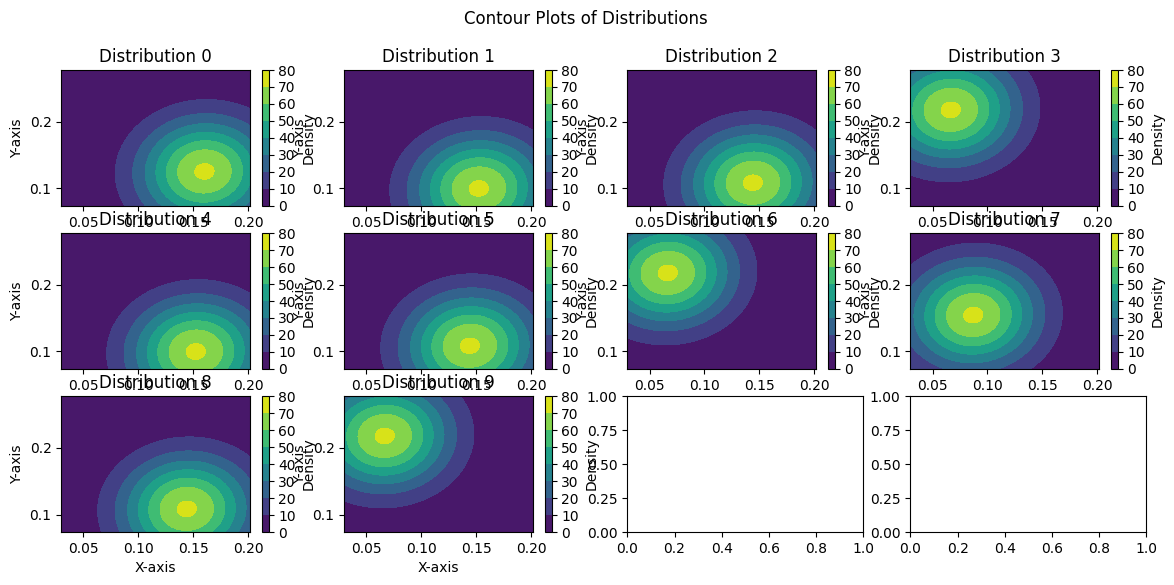

In [13]:
# Create the figure for 2D for model 4

plot_normal_contour(models_d1[9], x, y)

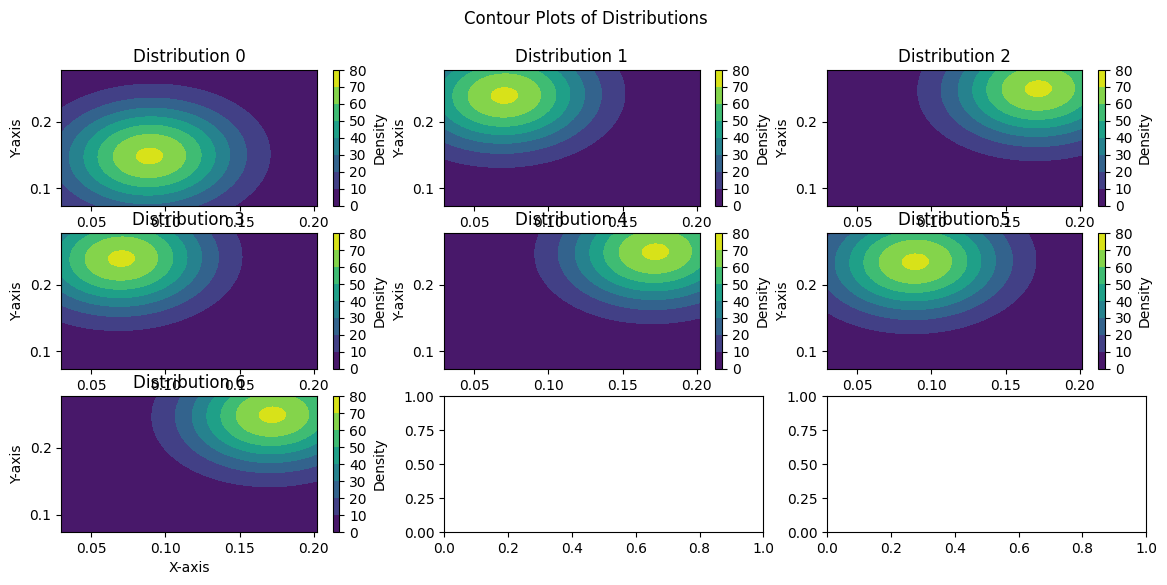

In [14]:
# Create the figure for 2D for model 6
plot_normal_contour(models_d1[best1], x, y)

Cluster #0
Cluster #1
Cluster #2
Cluster #3
Cluster #4
Cluster #5
Cluster #6
Cluster #7
Cluster #8
Cluster #9


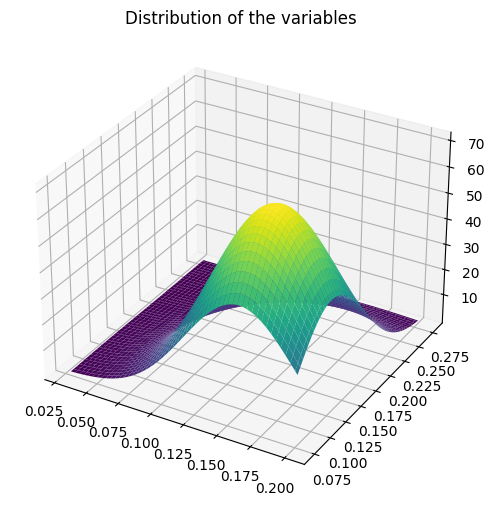

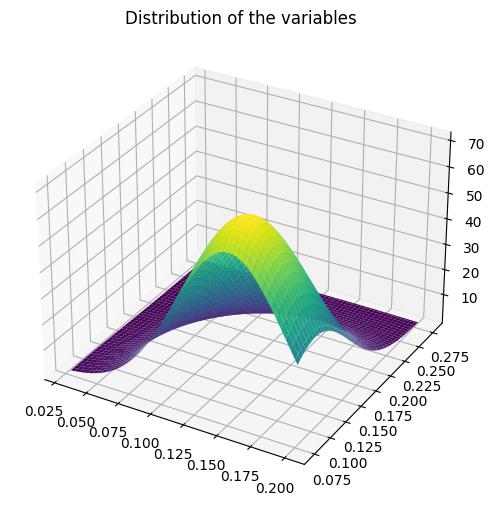

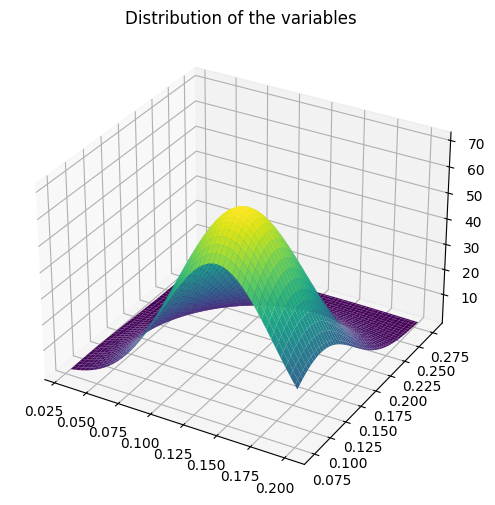

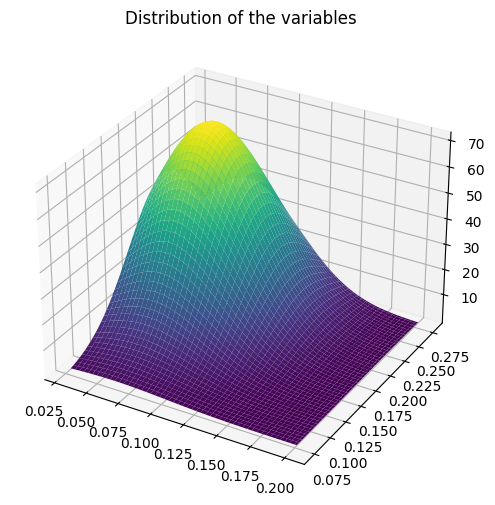

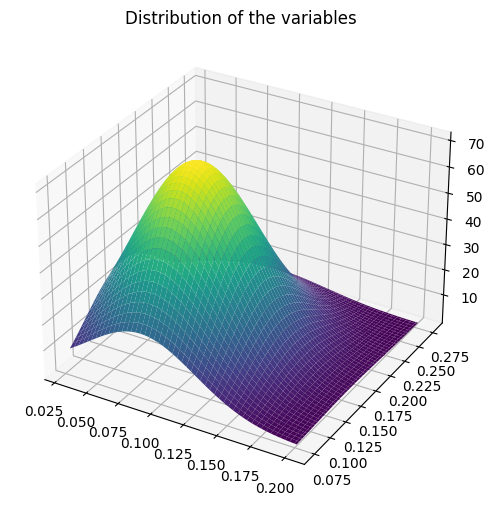

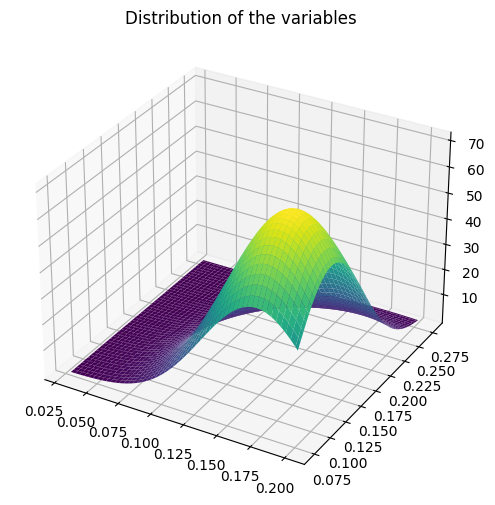

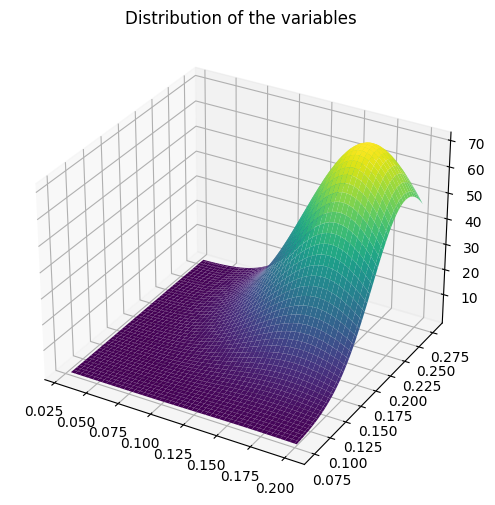

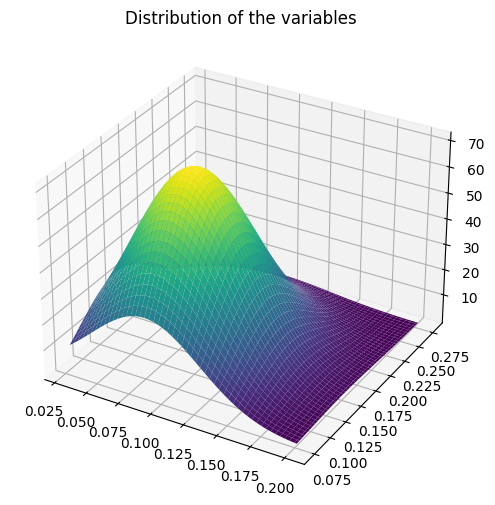

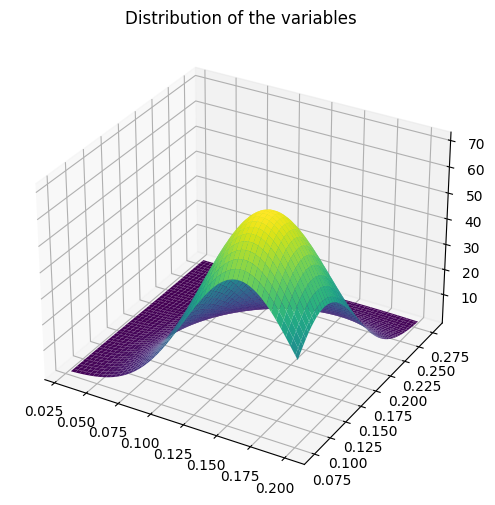

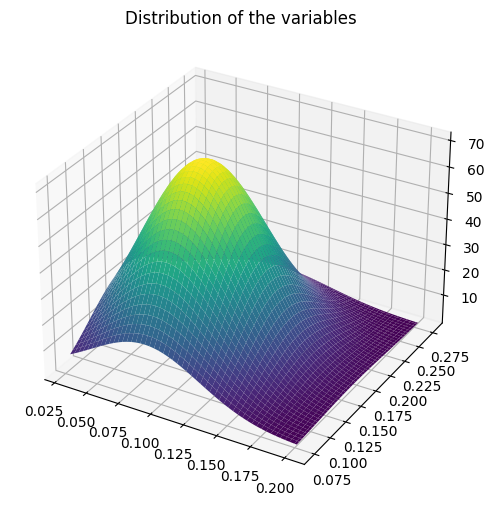

In [22]:
# Create the figure for 3D for model 4

contour_3d(x, y, models_d1[9])

Cluster #0
Cluster #1
Cluster #2
Cluster #3
Cluster #4
Cluster #5
Cluster #6


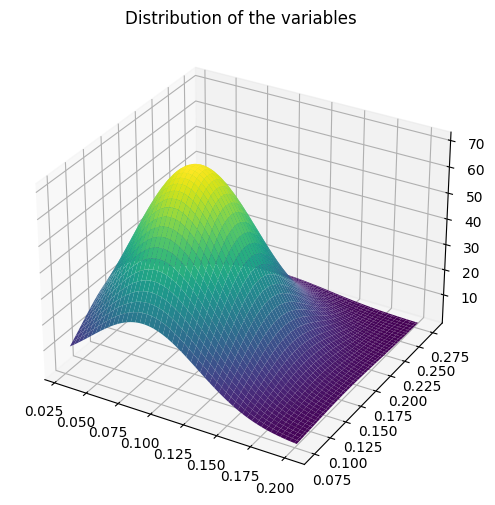

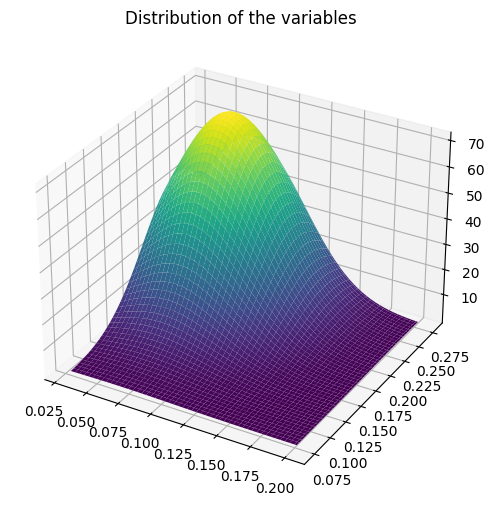

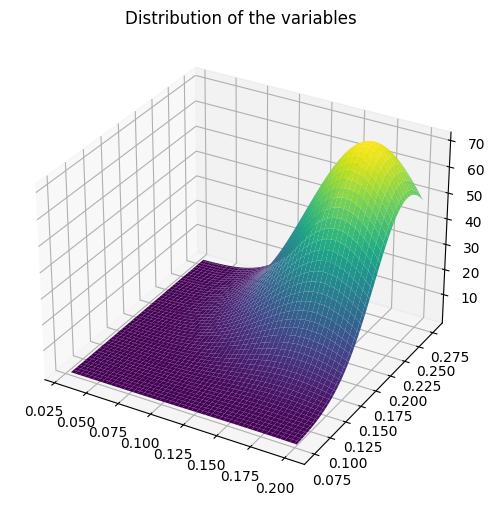

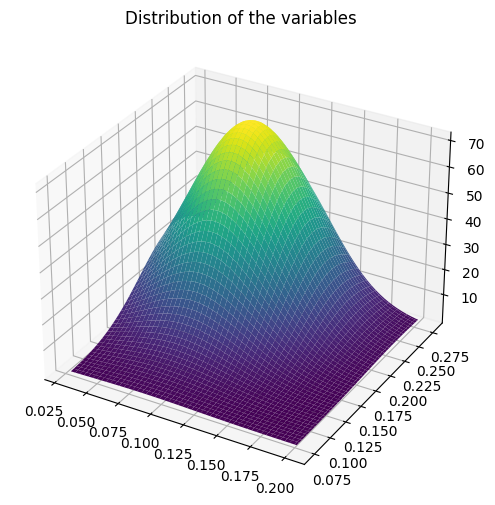

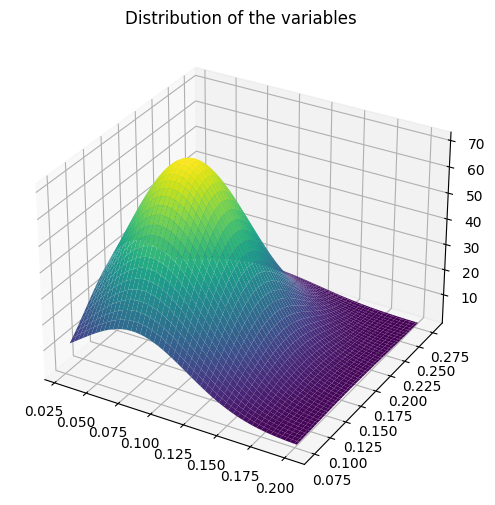

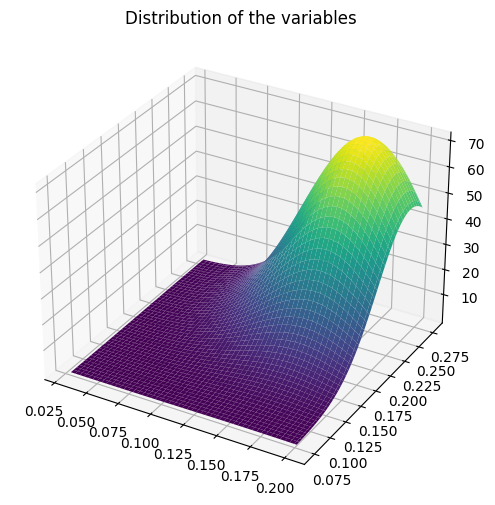

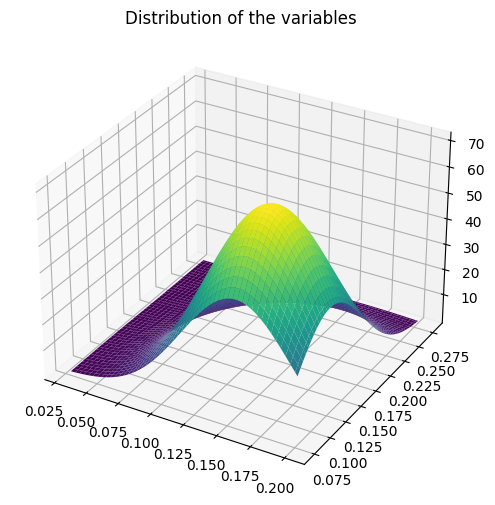

In [23]:
# Create the figure for 3D for model 6

contour_3d(x, y, models_d1[best1])

Each of these models roughly track with the visual clusters found when looking at the geographic location of the data.  One notable feature is that if compared with the original clustering, the models do not have any center on the north east cluster found when perusing the data.  The closest is distribution 4 and 6 in $k=7$ (model 6).  A look at the underlying data shows that the north east cluster has only average crime counts, suggesting that not much variance is explained by it.  However, it is also possible that the learned distributions failed to focus on that cluster due to problematic initialization.  The initial parameters for means come from random points and covariances are the data covariances.  Alternative covariances might suggest a different learned distribution.

Interestingly, it also looks like that the bottom right hand cluster was never picked up by these models.  This might fundamentally be down to an initialization problem.  However, it could also be that the count values are low in this area except at a missing intersection.

In [24]:
bics2, best2 = eval_models(models_d2, te_d2)
print(bics2)
print(best2)

[2086115.5407547625, 2134112.134598498, 2089756.0013254778, 2076572.318312801, 2074290.289829856, 2068883.2349360485, 2067225.8544285418, 2067688.6400215635, 2070586.2139321058, 2067544.2797856007]
6


In [25]:
excised = bics2[:6] + bics2[7:]
excised.index(min(excised))

8

Next we do the contour plots for the third dataset.  As a reminder, this data set had the sum and averages crime reports along with the counts.  Interestingly, every model was very close together in their loss.  The two top models were model 6 $k=7$ and model 8 $k=9$.

In [26]:
# Create the x, y coordinates for data set d2
x = np.linspace(np.amin(tr_d2[0]), np.amax(tr_d2[0]), num=100)
y = np.linspace(np.amin(tr_d2[1]), np.amax(tr_d2[1]), num=100)

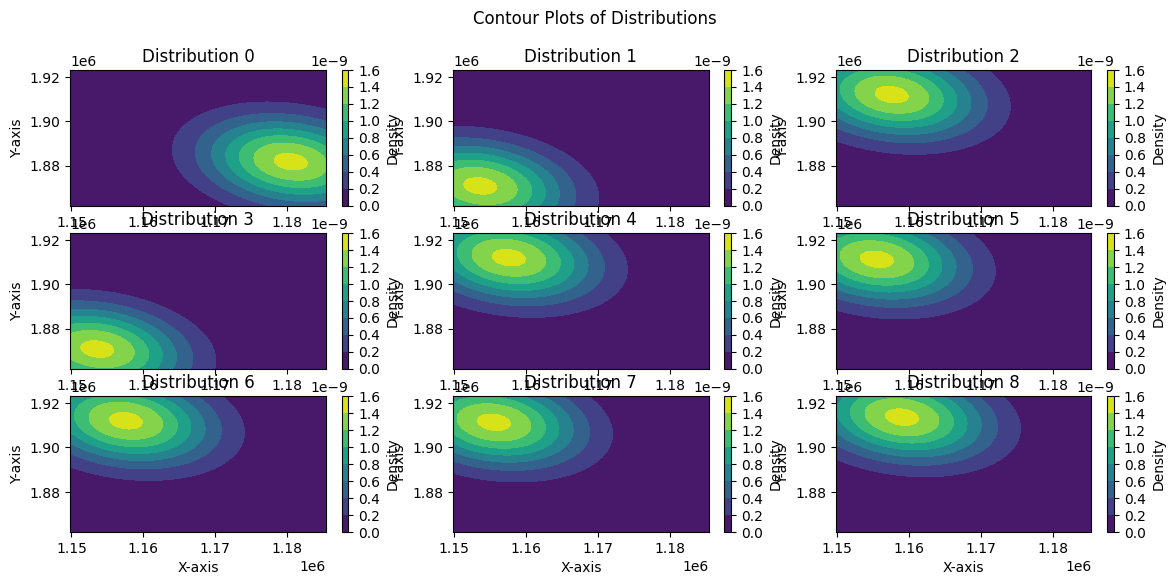

In [27]:
# Create the figure for 2d for model 8

plot_normal_contour(models_d2[8], x, y)

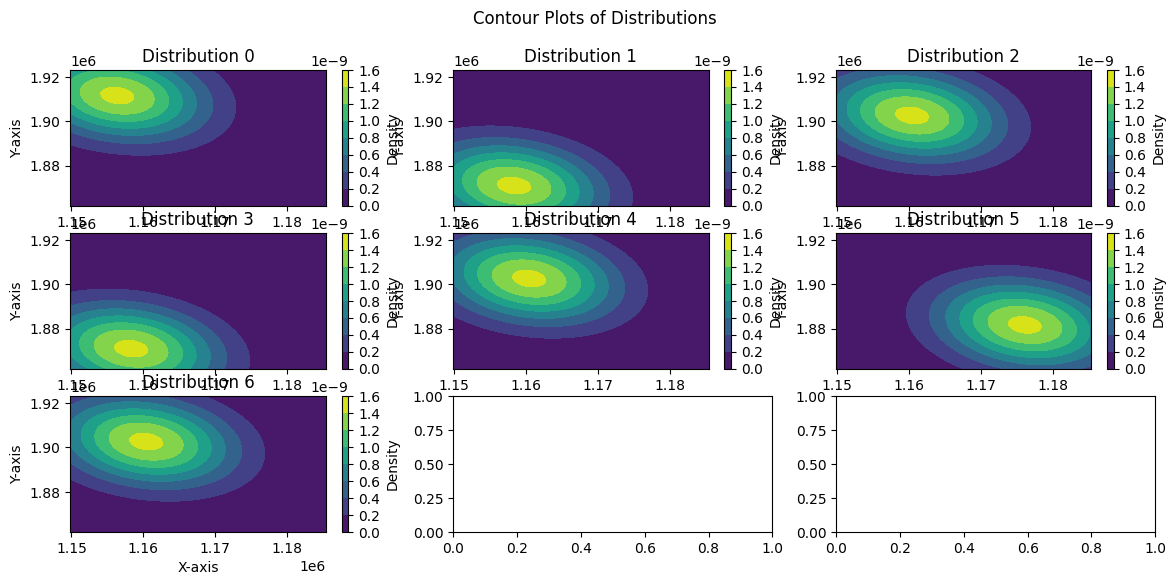

In [28]:
# Create the figure for 2D for model 6

plot_normal_contour(models_d2[best2], x, y)

Cluster #0
Cluster #1
Cluster #2
Cluster #3
Cluster #4
Cluster #5
Cluster #6
Cluster #7
Cluster #8


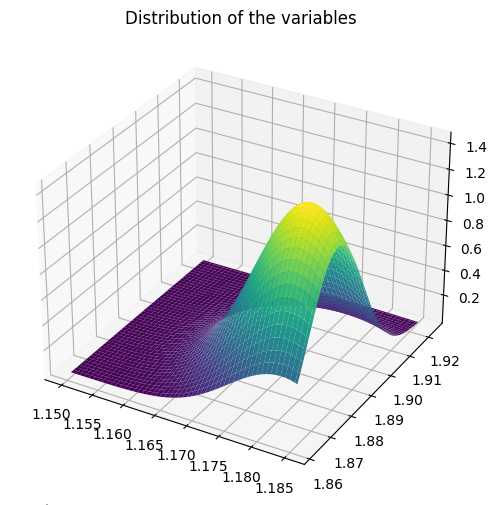

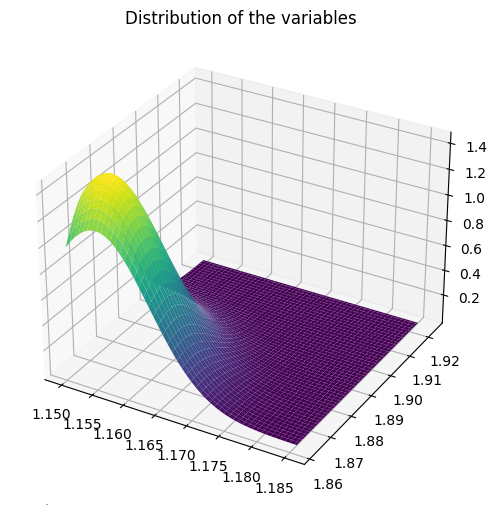

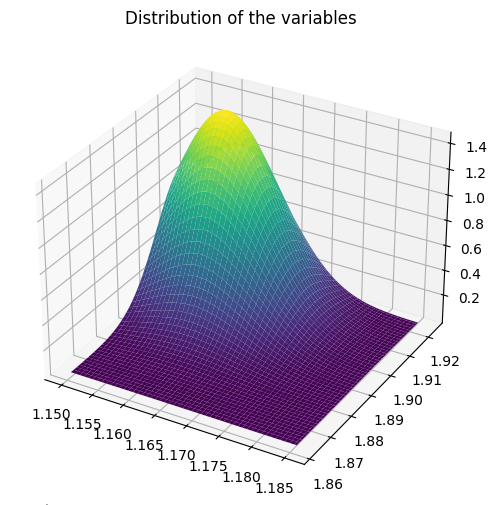

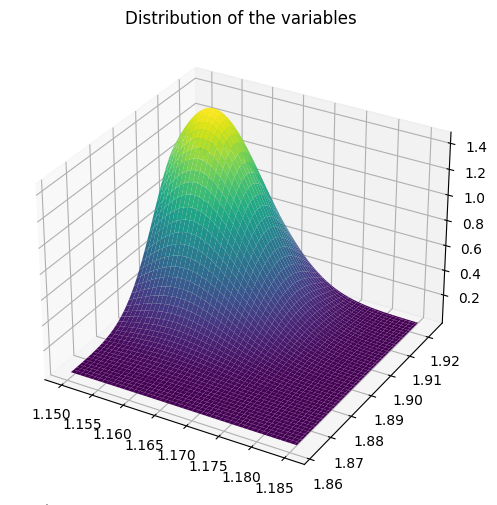

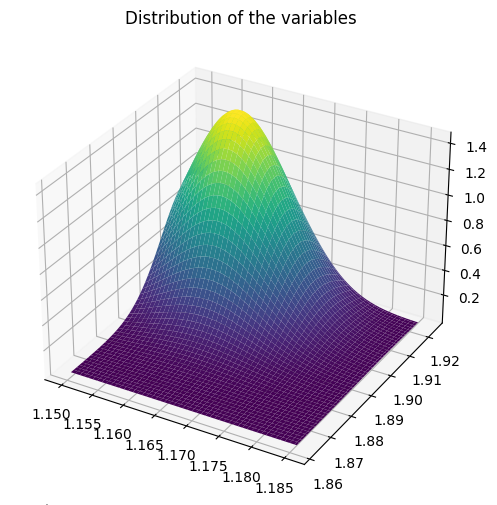

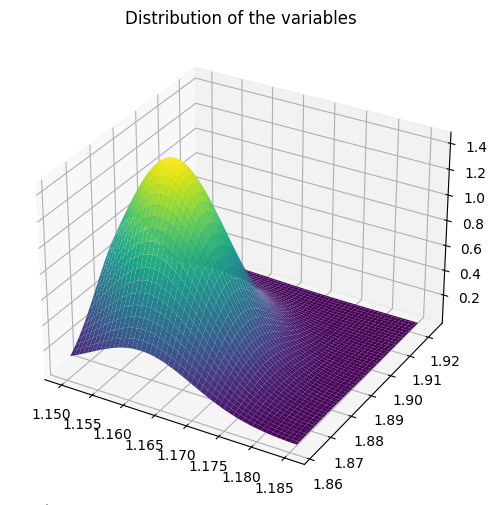

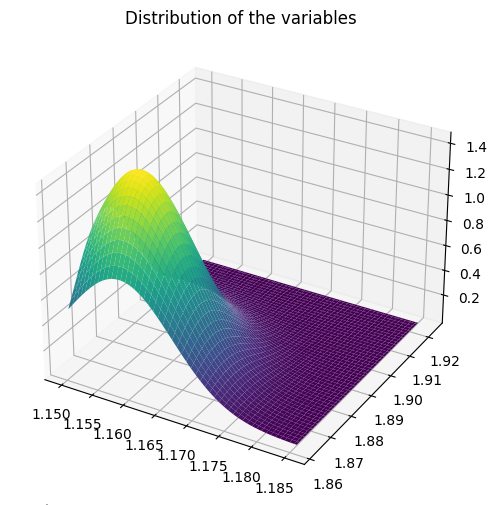

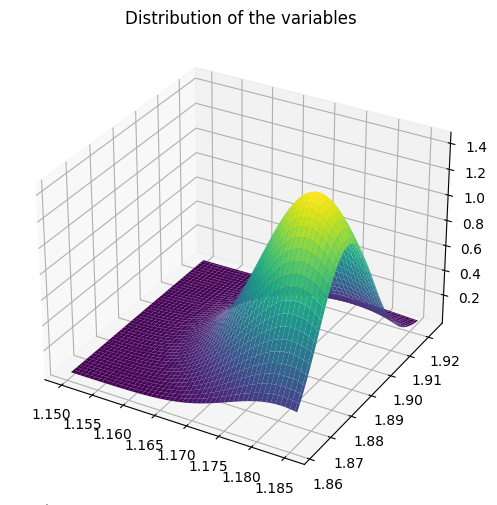

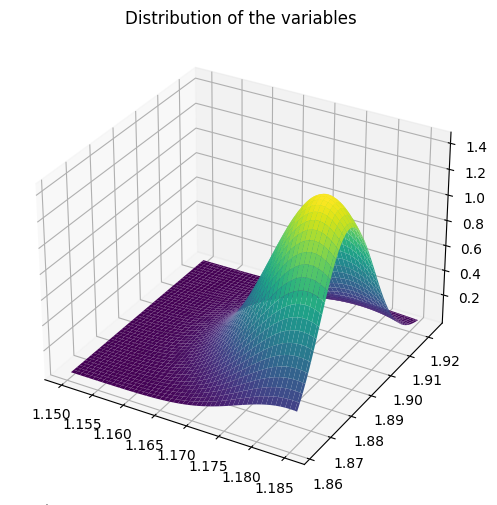

In [29]:
# Create the figure for 3D for model 8

contour_3d(x, y, models_d2[8])

Cluster #0
Cluster #1
Cluster #2
Cluster #3
Cluster #4
Cluster #5
Cluster #6


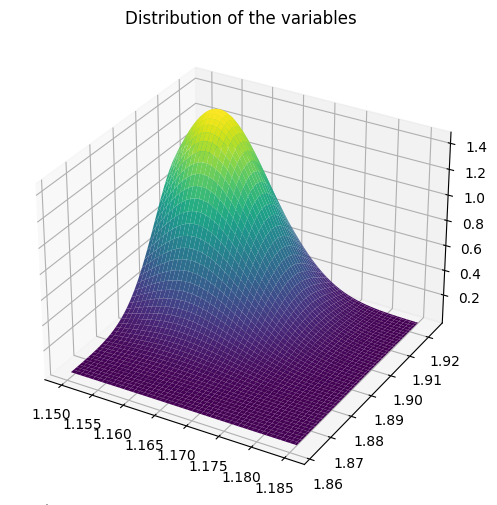

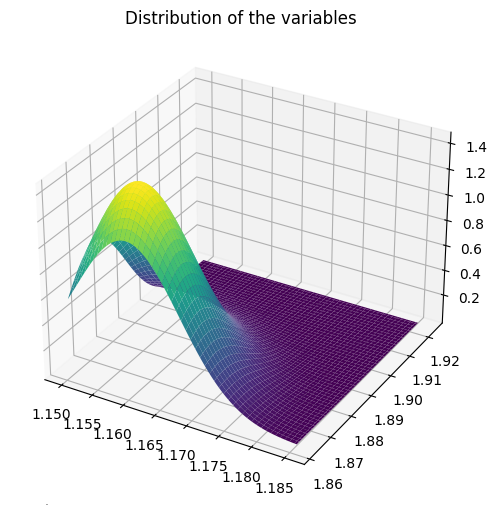

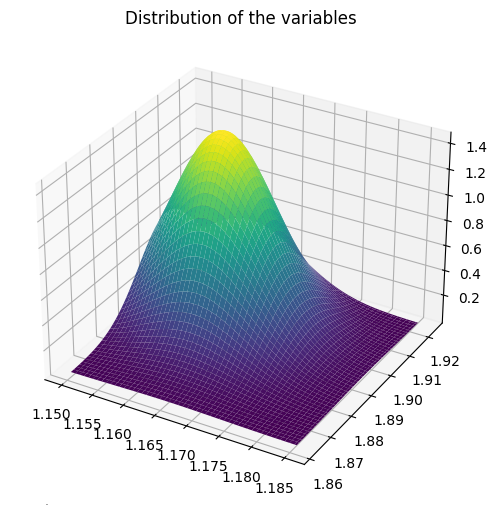

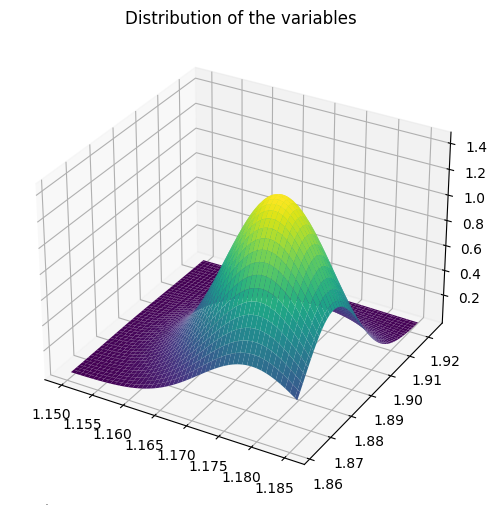

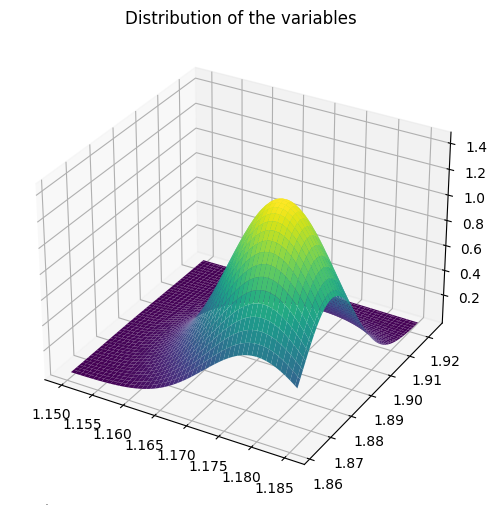

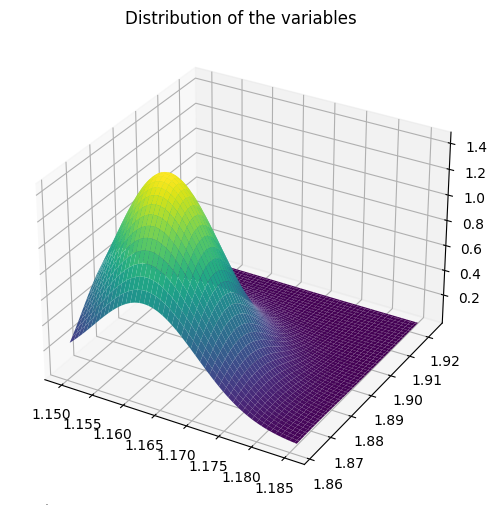

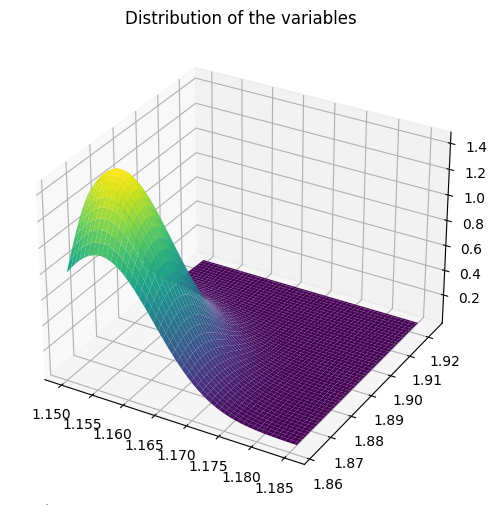

In [30]:
# Create the figure for 3D for model 6

contour_3d(x, y, models_d2[6])